# Read Samoan Passage model data

Read three-hourly output from Dimitris Menenmenlis 1/48° ocean model.

In [1]:
# %load /Users/gunnar/Projects/python/standard_imports.py
%matplotlib inline
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import xarray as xr

# import Samoan Passage Model Library (install from https://github.com/gunnarvoet/spmlib)
import spmlib as spl
# import own modules (install from https://github.com/gunnarvoet/pythonlib)
import gvpy as gv

from dask.diagnostics import ProgressBar

%reload_ext autoreload
%autoreload 2

## Load data

Set paths to model data here. If you are working at Scripps you can mount Rawaki over the network from kipapa.ucsd.edu and use the paths given below.

In [2]:
grid_path = '/Volumes/Rawaki/sp/grid'
data_path = '/Volumes/Rawaki/sp/'

First we generate an object that contains model grid information.

In [3]:
# generate model object
m = spl.data.generate_model_class(grid_dir=grid_path,
                             data_dir=data_path,
                             Nlon=936, Nlat=1062, Nz=90)

loading grid...
936x1062x90


Let's load all model variables for a few days. First generate a list of model time stamps to be read below.<br>
Model data is available from 2011-11-15 to 2012-11-14.<br>
Note that reading more than a month or so worth of data will take long.

In [4]:
time_range = spl.data.find_model_timestamps('2012-08-01', '2012-08-03 03:00:00')

----------------------------------------
generating list of model timestamps from
2012-08-01 00:00:00
to
2012-08-03 03:00:00
----------------------------------------


Model time stamps are based on the model start time 2011-09-10 00:00:00. Each model time step is 25s.

In [5]:
print(time_range[0])

1126656


Now feed the object with model grid information and the list of model time stamps into the function that generates the xarray Dataset.

The Dataset is not loaded into memory yet (for more information see [how xarray uses dask](http://xarray.pydata.org/en/stable/dask.html) for lazy evaluation). The function takes a three element tuple defining the chunk size  (z, y, x). Playing with chunk size shows that (20, 50, 50) is a pretty good choice. Smaller chunks take longer to generate the dataset, but the time needed to read individual data chunks decreases quite a bit.

In [6]:
d = spl.data.create_dataset_timeseries(m, time_range, chunks=(20, 50, 50))

chunks
time: (1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1)
xc: (50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 36)
xg: (50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 36)
yc: (50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 12)
yg: (50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 12)
z: (20, 20, 20, 20, 10)
zl: (20, 20, 20, 20, 10)


Now we have a Dataset containing all grid information and data variables:

In [7]:
d

<xarray.Dataset>
Dimensions:  (time: 18, xc: 936, xg: 936, yc: 1062, yg: 1062, z: 90, zl: 90, zp1: 91, zu: 90)
Coordinates:
  * xc       (xc) >f4 -176.98958 -176.96875 -176.94792 -176.92708 -176.90625 ...
  * yc       (yc) >f4 -19.99884 -19.980839 -19.962835 -19.944828 -19.92682 ...
  * xg       (xg) >f4 -177.0 -176.97917 -176.95833 -176.9375 -176.91667 ...
  * yg       (yg) >f4 -20.007841 -19.98984 -19.971836 -19.953833 -19.935825 ...
  * z        (z) >f4 0.5 1.57 2.79 4.185 5.78 7.595 9.66 12.01 14.68 17.705 ...
  * zl       (zl) float32 0.0 1.0 2.1399999 3.4399998 4.93 6.63 8.56 10.76 ...
  * zu       (zu) float32 1.0 2.1399999 3.4399998 4.93 6.63 8.56 10.76 13.26 ...
  * zp1      (zp1) float32 0.0 1.0 2.1399999 3.4399998 4.93 6.63 8.56 10.76 ...
    lon      (xc) float32 -176.98958 -176.96875 -176.94792 -176.92708 ...
    lat      (yc) float32 -19.99884 -19.980839 -19.962835 -19.944828 ...
    dxc      (yc, xg) float32 2176.5295 2176.5295 2176.5295 2176.5295 ...
    dyc      (yg, x

## Read and plot data at single point

Let's throw a virtual thermistor in there and plot a temperature time series from somewhere in the Samoan Passage. Note how this works relatively quickly as we don't have to read each field completely but can do with only a small chunk that contains the point of interest.

In [8]:
# find indices
def nearest_index(vector, value):
    return np.fabs(vector - [value]).argmin().squeeze()

Plot the data. Wrapping the process with `ProgressBar()` shows how long it takes to actually read the data into memory. Here we make use of xarray's plotting method that comes with all xarray data objects.

[########################################] | 100% Completed |  0.8s


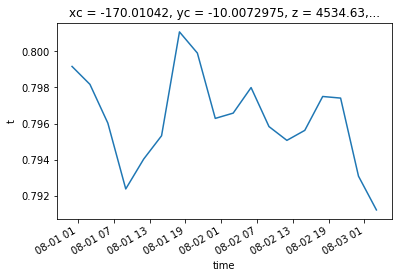

In [9]:
with ProgressBar():
    d.t.isel(yc=nearest_index(d.yc.data, -10),
             xc=nearest_index(d.xc.data, -170),
             z=nearest_index(d.z.data, 4500)
            ).plot()

We can also read the time series into its own DataArray:

In [10]:
th1 = d.t.isel(yc=nearest_index(d.yc.data, -10),
               xc=nearest_index(d.xc.data, -170),
               z=nearest_index(d.z.data, 4500))

In [11]:
th1

<xarray.DataArray 't' (time: 18)>
dask.array<shape=(18,), dtype=float32, chunksize=(1,)>
Coordinates:
    xc       >f4 -170.01042
    yc       >f4 -10.0072975
    z        >f4 4534.63
    lon      float32 -170.01042
    lat      float32 -10.0072975
    drf      float32 280.5
    ra       float32 4800908.0
    depth    float32 5089.7476
    hfacc    float32 1.0
  * time     (time) datetime64[ns] 2012-08-01 2012-08-01T03:00:00 ...

Note that this is still just a description of the data, the data hasn't been read into memory yet. We can explicitly load the data into memory by applying the `load()` method:

In [12]:
th1.load()

<xarray.DataArray 't' (time: 18)>
array([0.799163, 0.798172, 0.79603 , 0.792391, 0.79404 , 0.795331, 0.801073,
       0.799903, 0.796291, 0.796583, 0.797996, 0.795839, 0.795077, 0.79563 ,
       0.797503, 0.797414, 0.793096, 0.791231], dtype=float32)
Coordinates:
    xc       >f4 -170.01042
    yc       >f4 -10.0072975
    z        >f4 4534.63
    lon      float32 -170.01042
    lat      float32 -10.0072975
    drf      float32 280.5
    ra       float32 4800908.0
    depth    float32 5089.7476
    hfacc    float32 1.0
  * time     (time) datetime64[ns] 2012-08-01 2012-08-01T03:00:00 ...

The data is now an actual numpy array and not a dask.array.

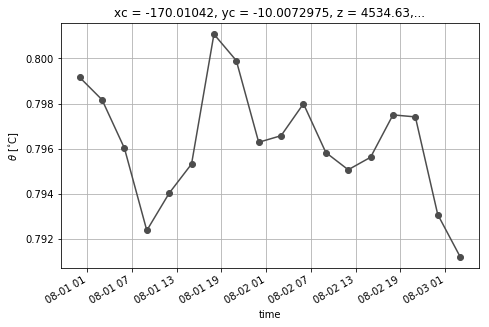

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7.5, 5))
th1.plot(color='0.3', linestyle='-', marker='o', ax=ax)
ax.grid()
ax.set(ylabel=r'$\theta$ [$^{\circ}$C]');

## Plot sections
Let's plot a couple sections of northward velocity and potential temperature along one latitude.

In [14]:
lati = -9.5
xi = np.where((d.xc.data>-171) & (d.xc.data<-168))[0]
yi = np.array(nearest_index(d.yc.data, lati))
zi = np.where(d.z.data>2500)[0]

Extract time-mean velocity and potential temperature fields:

In [15]:
with ProgressBar():
    v = d.v.isel(z=zi, yg=yi,xc=xi,).mean(dim='time').load()
    t = d.t.isel(z=zi, yc=yi,xc=xi,).mean(dim='time').load()

[########################################] | 100% Completed |  5.4s
[########################################] | 100% Completed |  4.5s


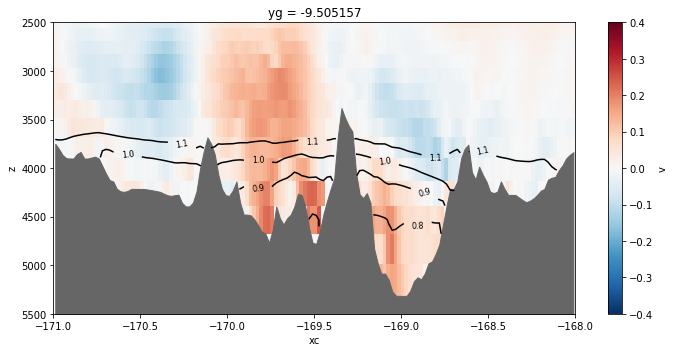

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))

# plot v
v.plot(ax=ax, vmax=0.4)

# plot bottom
ax.fill_between(t.xc, t.depth, np.ones_like(t.lon)*6000,color='0.4')

# contour theta
# mask the bottom (zeros) for nicer contours
tmp = np.ma.masked_equal(t, 0)
cs = ax.contour(t.xc, t.z, tmp, np.arange(0.8, 1.2, 0.1), colors='k')
ax.clabel(cs, inline=1, fontsize=8, fmt='%1.1f')
ax.set(ylim=(5500, 2500))
plt.tight_layout()

## Interpolate to cell centers

Note that in the above section velocity is still on its own grid and thus on a slightly different latitude than potential temperature. However, we can easily interpolate velocities to cell centers using [xgcm](https://github.com/xgcm/xgcm)!

In [17]:
import xgcm

In [18]:
grid = xgcm.Grid(d)
print(grid)

<xgcm.Grid>
Y Axis (periodic):
  * center   yc (1062) --> left
  * left     yg (1062) --> center
T Axis (periodic):
  * center   time (18)
Z Axis (periodic):
  * center   z (90) --> left
  * left     zl (90) --> center
  * outer    zp1 (91) --> center
  * right    zu (90) --> center
X Axis (periodic):
  * center   xc (936) --> left
  * left     xg (936) --> center


The object grid describes how the various axes relate to each other and provides methods for interpolation and differentiation. Here we interpolate velocity to cell centers.

In [19]:
# Let's drop some variables that are not needed
d2 = d.drop(['w', 'u', 's', 'eta', 'phibot'])

In [20]:
# Interpolate meridional velocity from cell faces to centers
d2['vc'] = grid.interp(d2.v, 'Y')

In [21]:
# drop meridional velocity now that we have a version centered on the grid cells
d2 = d2.drop('v')

Calculate the time mean and load data into memory.

In [22]:
with ProgressBar():
    d3 = d2.isel(z=zi, yc=yi, xc=xi,).mean(dim='time').load()

[########################################] | 100% Completed | 12.9s


Now we can plot on the same grid.

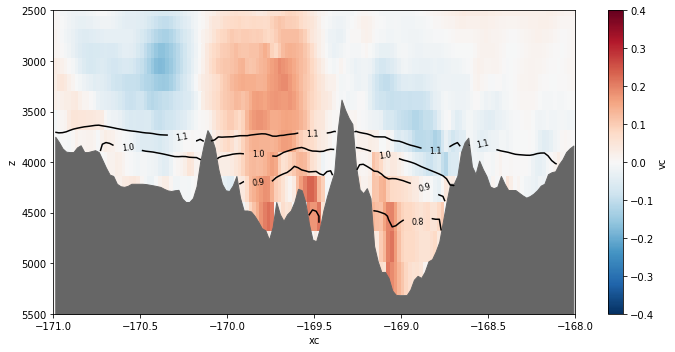

In [23]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))

# plot v
d3.vc.plot(ax=ax, vmax=0.4)

# plot bottom
ax.fill_between(d3.lon, d3.depth, np.ones_like(d3.lon)*6000,color='0.4')

# contour theta
# mask the bottom (zeros) for nicer contours
tmp = np.ma.masked_equal(d3.t, 0)
cs = ax.contour(d3.lon, d3.z, tmp, np.arange(0.8, 1.2, 0.1), colors='k')
ax.clabel(cs, inline=1, fontsize=8, fmt='%1.1f')
ax.set(ylim=(5500, 2500))
plt.tight_layout()

Doesn't look much different but now temperature and velocity are on the same grid.